# Task 1 : Set up colab gpu runtime environment

In [43]:
# %pip install segmentation-models-pytorch
# %pip install -U git+https://github.com/albumentations-team/albumentations
# %pip install --upgrade opencv-contrib-python

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

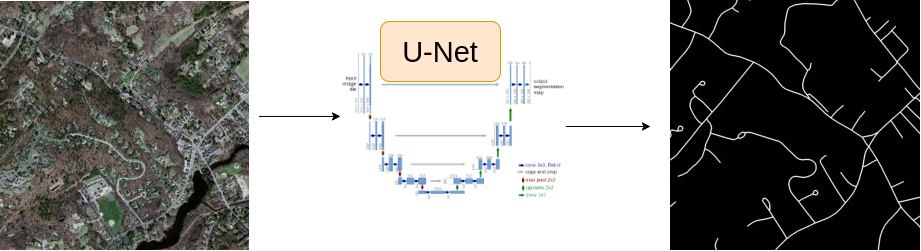

# Download Subset Dataset

In [44]:
# !git clone https://github.com/parth1620/Road_seg_dataset.git

# Some Common Imports

In [45]:
import sys
sys.path.append('./Road_seg_dataset')

In [46]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [47]:
DATA_DIR = '/home/btech/nityanand.mathur/Pytorch/AerialImageSegmentation/Road_seg_dataset/'
CSV_FILE = '/home/btech/nityanand.mathur/Pytorch/AerialImageSegmentation/Road_seg_dataset/train.csv'

EPOCH = 25
BATCH_SIZE = 8
IMG_SIZE = 512
LR = 0.003
DEVICE = 'cuda'

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [48]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [49]:
idx = 31

row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.IMREAD_GRAYSCALE)

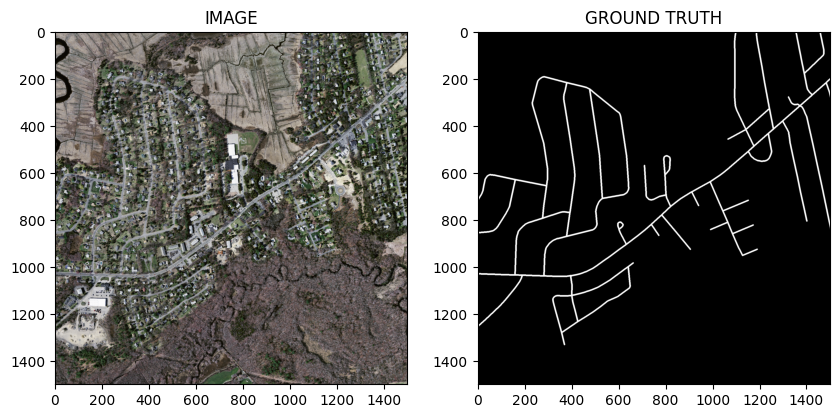

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [51]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [52]:
len(train_df)

159

In [53]:
len(valid_df)

40

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [54]:
import albumentations as A

In [78]:
def get_train_augs():
    return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE)
    ])

# Task 4 : Create Custom Dataset 

In [56]:
from torch.utils.data import Dataset

In [67]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = df.iloc[idx]

        image_path = DATA_DIR + row.images
        mask_path = DATA_DIR + row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h ,w)
        mask = np.expand_dims(mask, axis = -1) # (h, w, c)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) /255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [79]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [80]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


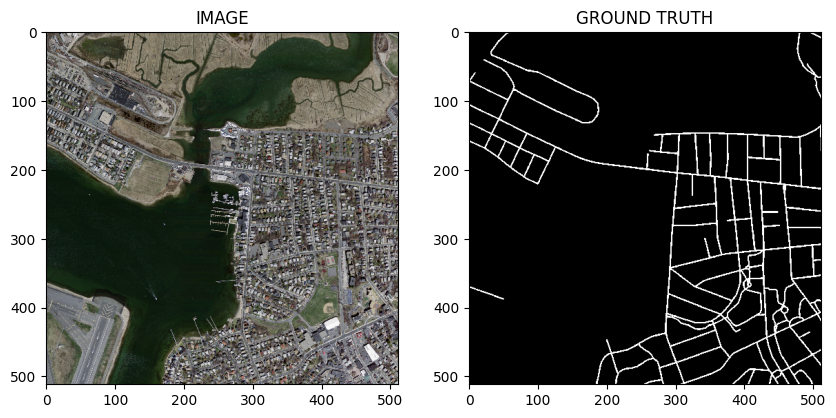

In [81]:
idx = 3

image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [61]:
from torch.utils.data import DataLoader

In [82]:
trainloader= DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [83]:
print(f'Total Batches in trainloader {len(trainloader)}')
print(f'Total Batches in validloader {len(validloader)}')

Total Batches in trainloader 20
Total Batches in validloader 5


In [84]:
for images, masks in trainloader:
    print(f"one batch image shape: {images.shape}")
    print(f"One batch mask sshape: {masks.shape}")
    break

one batch image shape: torch.Size([8, 3, 512, 512])
One batch mask sshape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [86]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [87]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
    
        self.backbone = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks = None):
        logits = self.backbone(images)
        if masks != None:
            return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits

In [88]:
model = SegmentationModel()
model = model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /home/btech/nityanand.mathur/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function 

In [94]:
def train_fn(dataloader, model, optimizer):
    model.train()

    total_loss = 0
    for images,masks in tqdm(dataloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(dataloader)

In [95]:
def valid_fn(dataloader, model):
    model.train()

    total_loss = 0
    with torch.no_grad():
        for images,masks in tqdm(dataloader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss/len(dataloader)

# Task 8 : Train Model

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [97]:
best_loss = np.Inf
for i in range(EPOCH):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = valid_fn(validloader, model)

    if valid_loss < best_loss:
        torch.save(model.state_dict(), "AIS.pt")
        print('MODEL SAVED')

        best_loss = valid_loss

    print(f"EPOCH: {i+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}")

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


MODEL SAVED
EPOCH: 1, Train Loss: 1.1316096156835556, Valid Loss: 0.8702382683753968


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


MODEL SAVED
EPOCH: 2, Train Loss: 0.7858211606740951, Valid Loss: 0.7328975677490235


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


MODEL SAVED
EPOCH: 3, Train Loss: 0.7154761344194412, Valid Loss: 0.706473433971405


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


MODEL SAVED
EPOCH: 4, Train Loss: 0.6892387747764588, Valid Loss: 0.6723843097686768


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


MODEL SAVED
EPOCH: 5, Train Loss: 0.6727848410606384, Valid Loss: 0.6620777249336243


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


EPOCH: 6, Train Loss: 0.6556626737117768, Valid Loss: 0.6926188349723816


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


MODEL SAVED
EPOCH: 7, Train Loss: 0.651488134264946, Valid Loss: 0.6549527168273925


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


MODEL SAVED
EPOCH: 8, Train Loss: 0.6586084991693497, Valid Loss: 0.6255309104919433


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


EPOCH: 9, Train Loss: 0.6411199063062668, Valid Loss: 0.6823739409446716


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


EPOCH: 10, Train Loss: 0.6262304157018661, Valid Loss: 0.6685482382774353


100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


MODEL SAVED
EPOCH: 11, Train Loss: 0.6232419058680534, Valid Loss: 0.6233047127723694


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


MODEL SAVED
EPOCH: 12, Train Loss: 0.610834413766861, Valid Loss: 0.6148290872573853


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


EPOCH: 13, Train Loss: 0.6146674960851669, Valid Loss: 0.6883397698402405


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


EPOCH: 14, Train Loss: 0.6215535283088685, Valid Loss: 0.633164894580841


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


EPOCH: 15, Train Loss: 0.6147627040743828, Valid Loss: 0.6182942271232605


100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


MODEL SAVED
EPOCH: 16, Train Loss: 0.5959778845310211, Valid Loss: 0.5874588131904602


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


MODEL SAVED
EPOCH: 17, Train Loss: 0.5955881416797638, Valid Loss: 0.5628472447395325


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH: 18, Train Loss: 0.6020900696516037, Valid Loss: 0.576974380016327


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


EPOCH: 19, Train Loss: 0.5892449527978897, Valid Loss: 0.574586832523346


100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


EPOCH: 20, Train Loss: 0.5836546868085861, Valid Loss: 0.6038694083690643


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


MODEL SAVED
EPOCH: 21, Train Loss: 0.5792944714426994, Valid Loss: 0.5605728805065155


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH: 22, Train Loss: 0.5687720656394959, Valid Loss: 0.6197574138641357


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


EPOCH: 23, Train Loss: 0.5710867375135422, Valid Loss: 0.5630276083946228


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


EPOCH: 24, Train Loss: 0.5687221795320511, Valid Loss: 0.5765282988548279


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

EPOCH: 25, Train Loss: 0.5661749482154846, Valid Loss: 0.6061644315719604


# Task 9 : Inference

In [99]:
idx = 17

model.load_state_dict(torch.load('/home/btech/nityanand.mathur/Pytorch/AerialImageSegmentation/AIS.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

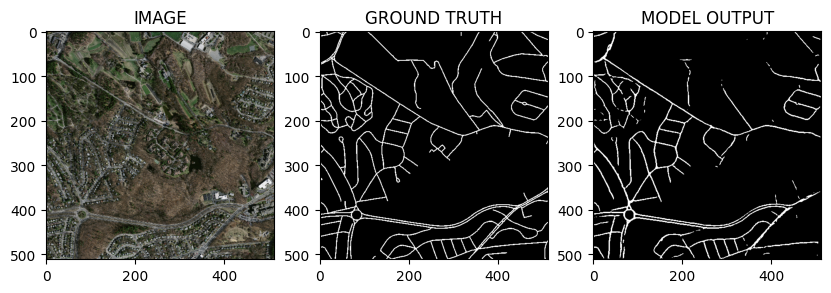

In [100]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))